Posición del satélite en t = 2025-04-01 00:00:00.000
r(t)   = 9658.323756713493 km
phi(t) = 3.238824938744 rad  (185.571000°)


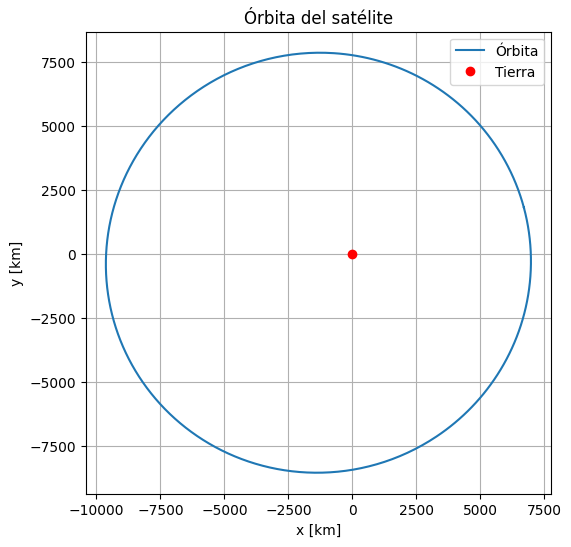


r0 = 9567.204450 km se alcanza en t = 2025-03-31 00:53:09.882
r(t_r0) = 9567.204450185 km (error = 0.000000185 km)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import math

# ============================================================================
# PARÁMETROS ORBITALES Y CONSTANTES
# ============================================================================
RE = 6378.1363            # km, radio "estándar" de la Tierra
GM = 398600.4405          # km^3/s^2, constante gravitacional de la Tierra
a  = 1.30262 * RE         # km, semieje mayor
e  = 0.16561              # excentricidad
omega_deg = 15.0          # argumento del pericentro (en grados)
omega = np.deg2rad(omega_deg)  # pasar a radianes

tp = Time("2025-03-31 00:00:00", format="iso", scale="utc")  # tiempo de paso por el pericentro

# ============================================================================
# 1) FUNCIÓN PARA RESOLVER LA ECUACIÓN DE KEPLER (MÉTODO DE NEWTON-RAPHSON)
# ============================================================================
def solve_kepler(l, e, tol=1e-14, max_iter=200):
    """
    Resuelve la ecuación de Kepler: E - e*sin(E) = l
    Parámetros:
        l        : anomalía media
        e        : excentricidad
        tol      : tolerancia para convergencia
        max_iter : iteraciones máximas
    Retorna:
        E        : anomalía excentrica
    """
    # Valor inicial: si e es pequeña, E0 ~ l; de lo contrario, un valor genérico (pi).
    E = l if e < 0.8 else math.pi
    for _ in range(max_iter):
        f  = E - e * np.sin(E) - l
        fp = 1 - e * np.cos(E)
        if abs(fp) < 1e-15:
            break
        dE = -f / fp
        E += dE
        if abs(dE) < tol:
            break
    return E

# ============================================================================
# 2) FUNCIÓN QUE, DADO UN INSTANTE t, CALCULA (r, phi)
# ============================================================================
def position(t):
    """
    Retorna (r, phi) en el instante t (astropy.time.Time):
      r   = distancia radial en km
      phi = ángulo en radianes (0 a 2π)
    """
    # 1) Calcular anomalía media l = n*(t - tp)
    dt = (t - tp).to_value('sec')  # diferencia de tiempo en segundos
    n  = np.sqrt(GM / a**3)       # movimiento medio
    l  = n * dt

    # 2) Resolver E a partir de la ecuación de Kepler
    E = solve_kepler(l, e)

    # 3) Calcular anomalía verdadera f mediante arctan2 (para cuadrante correcto)
    #    tan(f/2) = sqrt((1+e)/(1-e)) * tan(E/2)
    sin_E_2 = np.sin(E/2)
    cos_E_2 = np.cos(E/2)
    num = np.sqrt(1 + e) * sin_E_2
    den = np.sqrt(1 - e) * cos_E_2
    f = 2.0 * np.arctan2(num, den)  # f en [0, 2π)

    # Ajustar f a [0, 2π)
    f = f % (2.0 * np.pi)

    # 4) r = a*(1 - e^2) / (1 + e*cos(f))
    r = a * (1 - e**2) / (1 + e * np.cos(f))

    # 5) phi = f + omega (mod 2π)
    phi = (f + omega) % (2.0 * np.pi)

    return r, phi

# ============================================================================
# 3) FUNCIÓN PARA GRAFICAR LA ÓRBITA COMPLETA
# ============================================================================
def orbit(num_points=500):
    """
    Grafica la órbita del satélite a lo largo de un período.
    """
    # Período orbital
    T = 2.0 * np.pi * np.sqrt(a**3 / GM)
    dt_array = np.linspace(0, T, num_points)
    times = [tp + TimeDelta(dt, format='sec') for dt in dt_array]

    r_vals   = []
    phi_vals = []
    for tt in times:
        r_, phi_ = position(tt)
        r_vals.append(r_)
        phi_vals.append(phi_)

    r_vals   = np.array(r_vals)
    phi_vals = np.array(phi_vals)

    # Conversión a cartesianas
    x_vals = r_vals * np.cos(phi_vals)
    y_vals = r_vals * np.sin(phi_vals)

    plt.figure(figsize=(6,6))
    plt.plot(x_vals, y_vals, label="Órbita")
    plt.plot(0, 0, 'ro', label="Tierra")
    plt.axis('equal')
    plt.xlabel("x [km]")
    plt.ylabel("y [km]")
    plt.title("Órbita del satélite")
    plt.grid(True)
    plt.legend()
    plt.show()

# ============================================================================
# 4) FUNCIÓN PARA ENCONTRAR ÉPOCA t0 TAL QUE r(t0) = r0 USANDO BISECCIÓN
# ============================================================================
def date(r0, tol=1e-6):
    """
    Dado r0 (km), encuentra el instante t0 en el intervalo [tp, tp+T]
    en que r(t0) = r0, con una tolerancia 'tol' en km.
    Retorna un objeto astropy.time.Time (UTC) o None si no lo halla.
    """
    # Definimos g(t) = r(t) - r0
    # Usaremos una búsqueda de raíces por bisección en el intervalo [0, T].
    
    def g(sec):
        # r(t) - r0
        t_ = tp + TimeDelta(sec, format='sec')
        return position(t_)[0] - r0

    # Período orbital
    T = 2.0 * np.pi * np.sqrt(a**3 / GM)
    # Paso inicial para encontrar un cambio de signo
    # (puede ajustarse si no se encuentra cambio de signo).
    step = 60.0  # 60 segundos

    # 1) Hallar un bracket [t_a, t_b] con g(t_a)*g(t_b) < 0
    t_a = 0.0
    f_a = g(t_a)
    found_bracket = False

    while t_a < T:
        t_b = t_a + step
        if t_b > T:
            t_b = T
        f_b = g(t_b)

        # Revisamos si hay cambio de signo
        if f_a * f_b < 0:
            found_bracket = True
            break

        t_a = t_b
        f_a = f_b

    if not found_bracket:
        print("No se encontró cambio de signo para r(t) - r0 en [tp, tp+T].")
        return None

    # 2) Aplicar bisección en [t_a, t_b]
    for _ in range(200):  # Máximo 200 iteraciones
        t_m = 0.5 * (t_a + t_b)
        f_m = g(t_m)

        if abs(f_m) < tol:
            # Si la distancia es menor que la tolerancia, convergemos
            t_sol = tp + TimeDelta(t_m, format='sec')
            return t_sol

        # Ajuste del intervalo
        if f_a * f_m < 0:
            # la raíz está en [t_a, t_m]
            t_b = t_m
            f_b = f_m
        else:
            # la raíz está en [t_m, t_b]
            t_a = t_m
            f_a = f_m

    # Si llegamos aquí, no convergimos en las iteraciones dadas
    print("No hubo convergencia en la bisección para r0 =", r0)
    return None

# ============================================================================
# BLOQUE PRINCIPAL DE PRUEBA
# ============================================================================
if __name__ == '__main__':
    # 1) Verificación: posición en 2025-04-01 00:00:00 UTC
    t_test = Time("2025-04-01 00:00:00", format="iso", scale="utc")
    r_test, phi_test = position(t_test)

    print("Posición del satélite en t =", t_test.iso)
    print("r(t)   = {:.12f} km".format(r_test))
    print("phi(t) = {:.12f} rad  ({:.6f}°)".format(phi_test, np.degrees(phi_test)))

    # 2) Graficar la órbita
    orbit()

    # 3) Buscar instante en que r0 = 1.5 * RE
    r0_test = 1.5 * RE
    t_r0 = date(r0_test, tol=1e-6)
    if t_r0 is not None:
        r_calc = position(t_r0)[0]
        print("\nr0 = {:.6f} km se alcanza en t = {}".format(r0_test, t_r0.iso))
        print("r(t_r0) = {:.9f} km (error = {:.9f} km)".format(r_calc, abs(r_calc - r0_test)))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import math

# ============================================================================
#                                PARÁMETROS 

# ============================================================================
RT = 6378.1363            # Radio de la Tierra
GM = 398600.4405          # km^3/s^2
a  = 1.30262 * RT         # km, semieje mayor
e  = 0.16561              # excentricidad
omega_grad = 15.0          # argumento del pericentro (en grados)
omega = np.deg2rad(omega_grad)  # omega a radianes

tp = Time("2025-03-31 00:00:00", format="iso", scale="utc")  # tiempo de paso por el pericentro
tp.sec

<Time object: scale='utc' format='iso' value=2025-03-31 00:00:00.000>